# **LSTM: Long Short-Term Memory**

## **Librerías y modulos necesarios**

In [ ]:
# Modelado y Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scikeras.wrappers import KerasClassifier

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Análisis y manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Utilidades
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import pickle
import joblib


## **Explicación del modelo**

```{admonition} ¿Qué es LSTM?
LSTM es un tipo de red neuronal recurrente (RNN) diseñada para resolver el problema del desvanecimiento del gradiente que ocurre en las RNN tradicionales cuando se procesan secuencias largas. Las RNN tradicionales tienen dificultades para recordar información relevante de entradas pasadas a medida que se procesan nuevas entradas, especialmente cuando la secuencia es larga. LSTM fue creado específicamente para superar este desafío.

```

**¿Cómo funciona LSTM**

El modelo LSTM introduce una memoria a largo plazo a través de unidades llamadas celdas de memoria. Estas celdas tienen tres puertas principales:

1. Puerta de entrada: Controla cuánta de la información de la entrada actual debe ser guardada en la memoria.

2. Puerta de olvido: Decide qué información de la memoria pasada debe ser descartada.

3. Puerta de salida: Decide qué parte de la memoria actual debe ser usada para la predicción o salida.

En el procesamiento de lenguaje natural (NLP) se pueden implementar redes neuronales como LSTM para ``análisis de sentimiento``. En éste último LSTM se utiliza para clasificar sentimientos en un texto, como en el caso de las reseñas de productos (positivas o negativas). El modelo puede entender las dependencias entre las palabras para decidir si el sentimiento general del texto es positivo o negativo.

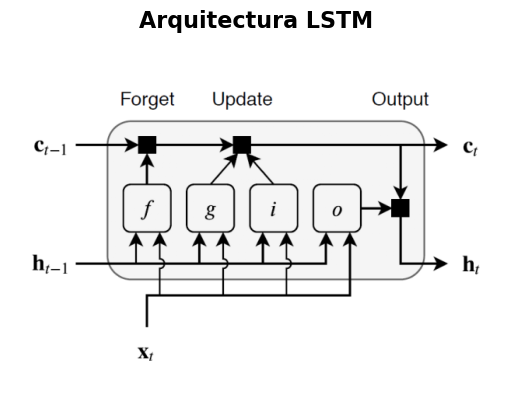

In [8]:
img = mpimg.imread('C:/Users/henry/Documents/jbook/project_NLP1/images/Arquitectura LSTM.png')
plt.imshow(img)
plt.axis('off') 
plt.title('Arquitectura LSTM', fontsize=16, fontweight='bold')
plt.show()

## **Conjunto de datos**

In [9]:
datapath = 'C:/Users/henry/Documents/jbook/project_NLP1/datos/'
data = pd.read_csv(datapath + 'to_models.csv')

## **Implementación del modelo**

In [10]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

In [11]:
def tokenize(text):
    tokens = []
    if isinstance(text, str):  # Asegúrate de que el texto sea una cadena
        for sent in nltk.sent_tokenize(text):
            for word in nltk.word_tokenize(sent):
                if len(word) <= 0:
                    continue
                tokens.append(word.lower())  # Corregido "lowwer" a "lower"
    return tokens

train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize(r['message'] if isinstance(r['message'], str) else ""), tags=[r.label]), axis=1)
test_tagged  = test.apply(lambda r: TaggedDocument(words=tokenize(r['message'] if isinstance(r['message'], str) else ""), tags=[r.label]), axis=1)


In [12]:
# Replace NaN values in the 'message' column with an empty string
data['message'] = data['message'].fillna('')

# Process the 'message' column to split words and count unique words
all_words = list(itertools.chain.from_iterable(data['message'].apply(lambda x: x.split())))
word_counts = Counter(all_words)
print(f"Total de palabras únicas: {len(word_counts)}")

Total de palabras únicas: 27217


In [13]:
max_features = 6000
data['message'].apply(lambda x: len(x.split())).describe()

count    10998.000000
mean        10.717494
std         12.533056
min          0.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        243.000000
Name: message, dtype: float64

In [14]:
MAX_SEQUENCE_LENGTH = 100

In [15]:
max_features = 5000  
embedding_dim = 50 

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[$$^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['message'].values)
X = tokenizer.texts_to_sequences(data['message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Found %s unique tokens.' % len(X))
print('Shape of data tensor:', X.shape)

Found 10998 unique tokens.
Shape of data tensor: (10998, 100)


In [16]:
train_tagged.values

array([TaggedDocument(words=['hahahaha', 'mogambo', 'khush'], tags=['Positivo']),
       TaggedDocument(words=['inquiry', 'chahye'], tags=['Positivo']),
       TaggedDocument(words=['wese', 'twitter', 'nazar', 'twitter', 'ronaq', 'dobala'], tags=['Positivo']),
       ...,
       TaggedDocument(words=['baron', 'hsla', 'afzai', 'hee', 'hamarey', 'hey'], tags=['Positivo']),
       TaggedDocument(words=['fia', 'dar', 'dr', 'asim', 'case', 'zidha', 'big', 'musharf', 'article', 'afsos', 'sahaft'], tags=['Negativo']),
       TaggedDocument(words=['adeel', 'boss', 'pyar', 'bhara'], tags=['Positivo'])],
      dtype=object)

In [17]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=12, alpha=0.065, min_alpha=0.065)

In [18]:
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

  0%|          | 0/8798 [00:00<?, ?it/s]

100%|██████████| 8798/8798 [00:00<00:00, 901487.43it/s]


In [19]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 8798/8798 [00:00<?, ?it/s]


CPU times: total: 31.9 s
Wall time: 28 s


In [20]:
print(d2v_model)

Doc2Vec<dm/m,d20,n5,w8,s0.001,t12>


In [21]:
num_words = len(d2v_model.wv.key_to_index)
print(num_words)

23871


In [22]:
words = d2v_model.wv.index_to_key
print(words[-10:])

['noqsan', 'lapait', 'zarye', 'westren', 'chatpati', 'daffinetly', 'boldiya', 'paktoon', 'nalaqe', 'sahaft']


A continuación se entrenan los embeddings del modelo para poder realizar la hiperparametrización.

In [23]:
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index)+ 1, 20))

In [24]:
for i in range(len(d2v_model.dv)):
    vec = d2v_model.dv[i]
    if vec is not None and len(vec) <= 1000:
        print(i)
        print(d2v_model.dv)
        embedding_matrix[i] = vec
        print(vec)

0
KeyedVectors<vector_size=20, 2 keys>
[-1.9714514  -5.4826536  -5.7209587   5.0201735  -1.8327352   0.77948856
 -5.798166   -1.3423945  -7.014486    0.9581067   1.9674205   2.1265843
 -0.21776435  2.4698067  -1.6813586  -7.979212   -1.7546194   0.8601482
 -5.6305523  -2.8048663 ]
1
KeyedVectors<vector_size=20, 2 keys>
[-4.1609955   4.4109273   0.06814498  0.43127668  5.395993   -4.3485327
 -2.8430548  -3.974455    3.8299487  -4.737384    3.9966888   3.586174
 -2.854323   -3.9266622   0.29949522  3.9545445  -0.06631717 -0.32688797
 -0.84780633  2.3050153 ]


In [25]:
d2v_model.wv.most_similar(positive=['pakistan'], topn=10)

[('dilwaan', 0.7817076444625854),
 ('siyaasat', 0.7614884972572327),
 ('tekana', 0.7582828402519226),
 ('dheshet', 0.7561725974082947),
 ('darmayam', 0.7557976841926575),
 ('kamzarf', 0.7512086033821106),
 ('shaksiat', 0.7463119029998779),
 ('otha', 0.745349109172821),
 ('1000000', 0.7435755133628845),
 ('maaro', 0.7435103058815002)]

### Parámetros del modelo

En la ejecución de la arquitectura de la red LSTM se implementan parámetros que ajustan las predicciones. A continuación se muestra una lista y descripción de los mismos:

In [26]:
"""
param_grid_lstm = {
    'lstm_units': [64, 128, 256],
    'num_lstm_layers': [1, 2, 3],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.005, 0.01],
    'batch_size': [32, 64, 128],
    'sequence_length': [50, 100, 200],
    'epochs': [20, 50, 100],
    'embedding_dim': [100, 200, 300]
}
"""

"\nparam_grid_lstm = {\n    'lstm_units': [64, 128, 256],\n    'num_lstm_layers': [1, 2, 3],\n    'dropout_rate': [0.2, 0.3, 0.5],\n    'learning_rate': [0.001, 0.005, 0.01],\n    'batch_size': [32, 64, 128],\n    'sequence_length': [50, 100, 200],\n    'epochs': [20, 50, 100],\n    'embedding_dim': [100, 200, 300]\n}\n"

```{admonition} **lstm_units**
Representa el número de unidades (neuronas) en la capa LSTM. Controla la capacidad del modelo para aprender patrones y memorizar dependencias en los datos secuenciales.

- Más unidades: El modelo tendrá más capacidad para aprender patrones complejos, pero puede volverse más lento y propenso a sobreajuste.
- Menos Unidades: El modelo puede ser más rápido, pero tendrá menor capacidad para aprender patrones complejos.
```

Valores posibles: ``[64, 128, 256]``

``**num_lstm_layers**`` : Indica el número de capas LSTM apiladas en la red. y tiene como valores en esta hiperparametrización = ``[1, 2, 3]``

```{admonition} **Droptout_rate**
Es la fracción de nodos que se desconectan aleatoriamente durante el entrenamiento para evitar el sobreajuste.

- Valores posibles: ``[0.2, 0.3, 0.5]``
```

**Learning_Rate**: La tasa de aprendizaje controla la magnitud de las actualizaciones en los pesos del modelo durante el entrenamiento. Entre mayor sea, el modelo puede aprender más rápido, pero corre el riesgo de no converger o saltarse el mínimo óptimo. Mientas que si es más baja, el modelo se entrenaría más lentamente y tiene menos probabilidades de saltarse mínimos locales, pero podría quedarse atrapado en un mínimo subóptimo si es demasiado baja. 

- Valores posibles: ``[0.001, 0.005, 0.01]``

- **``Batch_size``** = El tamaño del lote de datos que se usa para cada paso de entrenamiento. Tamaños pequeños de batch ayudan a una mejor generalización, pero mayor tiempo de entrenamiento y más ruido en la actualización de los pesos, mientras que tamaños grandes de batch generan menos ruido, pero puede ser más propenso al sobreajuste y podría no generalizar tan bien. Valores posibles = ``[32, 64, 128]``

```{admonition} Sequence_length
La longitud máxima de las secuencias de texto que se alimentan a la red. Los textos más largos se truncarán y los más cortos se rellenarán con ceros. Si se elige una longitud de secuencia más larga, se pierde más información de los mensajes largos, pero los mensajes cortos se mantienen completos.

- Valores posibles = [50, 100, 200]
```

```{admonition} Embedding_dim
La dimensión de los vectores de palabras en la capa de embeddings. Define el tamaño de los vectores que representan las palabras. Vectores pequeños tienen menos capacidad para capturar significados semánticos ricos, pero más rápido de entrenar. y vectores grandes tienen más capacidad para capturar semántica rica, pero más costoso computacionalmente.

- valores posibles = [100, 200, 300]

```

## Hiperparametrización para LSTM

In [27]:
print(train['label'].isnull().sum())

le = LabelEncoder()
y = le.fit_transform(train['label'])

#dImensiones
print(X.shape)  
print(len(y)) 

0
(10998, 100)
8798


In [28]:
print(train.shape)
print(test.shape)


(8798, 3)
(2200, 3)


**Parámetros a optimizar**

In [29]:
param_grid_lstm = {
    'lstm_units': [64, 128, 256],
    'num_lstm_layers': [1, 2, 3],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.005, 0.01],
    'batch_size': [32, 64, 128],
    'sequence_length': [50, 100, 200],
    'epochs': [20, 50],
    'embedding_dim': [100, 200, 300]
}

In [30]:
grid = ParameterGrid(param_grid_lstm)

In [ ]:
# Combinaciones
for params in grid:
    sequence_length = params['sequence_length'] #Del conjunto de parámetros
    X_train = tokenizer.texts_to_sequences(train['message'].values)
    X_train = pad_sequences(X_train, maxlen=sequence_length)

    # test
    X_test = tokenizer.texts_to_sequences(test['message'].values)
    X_test = pad_sequences(X_test, maxlen=sequence_length)
    le = LabelEncoder()
    y_train = le.fit_transform(train['label'])  
    y_test = le.transform(test['label'])  

    #modelo LSTM
    model = Sequential()
    #Capa de embedding
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=sequence_length))
    # Capa LSTM
    model.add(LSTM(units=params['lstm_units'], return_sequences=False))
    model.add(Dropout(params['dropout_rate']))
    #Capa densa para la salida
    model.add(Dense(1, activation='sigmoid'))  
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=params['learning_rate']), metrics=['accuracy'])
    print(f"Entrenando modelo con parámetros: {params}")
    model.summary()

    # modelo
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2)
    score = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {score[0]}")
    print(f"Test Accuracy: {score[1]}")



Entrenando modelo con parámetros: {'batch_size': 32, 'dropout_rate': 0.2, 'embedding_dim': 100, 'epochs': 20, 'learning_rate': 0.001, 'lstm_units': 64, 'num_lstm_layers': 1, 'sequence_length': 50}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1193550   
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,223,055
Trainable params: 1,223,055
Non-trainable params: 0
_______________________________________________

Se escogen los mejores parámetros

Con un ``Test Accuracy de 0.7514 (75.14%)``, se escogen:
- lstm_units:	64
- num_lstm_layers:	1
- dropout_rate:	0.2
- learning_rate:	0.001
- batch_size:	32
- sequence_length:	200
- epochs:	20
- embedding_dim:	100


## Modelo final con los mejores parámetros

In [48]:
lstm_units = 64
num_lstm_layers = 1
dropout_rate = 0.2
learning_rate = 0.001
batch_size = 32
sequence_length = 200
epochs = 20
embedding_dim = 100

In [49]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

# Tokenización
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(train['message'].values)
X_train = tokenizer.texts_to_sequences(train['message'].values)
X_train = pad_sequences(X_train, maxlen=sequence_length)
X_test = tokenizer.texts_to_sequences(test['message'].values)
X_test = pad_sequences(X_test, maxlen=sequence_length)

In [50]:
# Codificación de etiquetas
le = LabelEncoder()
y_train = le.fit_transform(train['label'])
y_test = le.transform(test['label'])

In [51]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=embedding_dim,
                    input_length=sequence_length))
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

In [52]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

In [53]:
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
220/220 [==============================] - 22s 87ms/step - loss: 0.5897 - accuracy: 0.6770 - val_loss: 0.5606 - val_accuracy: 0.6955
Epoch 2/20
220/220 [==============================] - 25s 115ms/step - loss: 0.4168 - accuracy: 0.8100 - val_loss: 0.5510 - val_accuracy: 0.7273
Epoch 3/20
220/220 [==============================] - 22s 99ms/step - loss: 0.2951 - accuracy: 0.8697 - val_loss: 0.6109 - val_accuracy: 0.7307
Epoch 4/20
220/220 [==============================] - 8s 36ms/step - loss: 0.2243 - accuracy: 0.9035 - val_loss: 0.6929 - val_accuracy: 0.7273
Epoch 5/20
220/220 [==============================] - 7s 32ms/step - loss: 0.1659 - accuracy: 0.9302 - val_loss: 0.8632 - val_accuracy: 0.7278
Epoch 6/20
220/220 [==============================] - 10s 45ms/step - loss: 0.1298 - accuracy: 0.9504 - val_loss: 0.9107 - val_accuracy: 0.7364
Epoch 7/20
220/220 [==============================] - 9s 40ms/step - loss: 0.0990 - accuracy: 0.9614 - val_loss: 1.0628 - val_accuracy: 0

In [54]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'\nTest Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

69/69 [==============================] - 2s 17ms/step - loss: 1.6236 - accuracy: 0.7436

Test Loss: 1.6236
Test Accuracy: 0.7436


Los resultados obtenidos muestran un comportamiento interesante en el proceso de entrenamiento del modelo LSTM. A lo largo de las épocas, se observa una mejora sostenida en la capacidad del modelo para ajustar sus parámetros al conjunto de entrenamiento, reflejada en un aumento progresivo de la precisión y una disminución de la función de pérdida. Sin embargo, se puede apuntar a un posible sobreajuste ya que las métricas en el conjunto de validación son evidentemente menores.

Una posible explicación para este comportamiento es que el modelo ha adquirido una alta sensibilidad a los patrones específicos del conjunto de entrenamiento, pero no ha logrado capturar representaciones más abstractas que sean útiles fuera de ese conjunto.


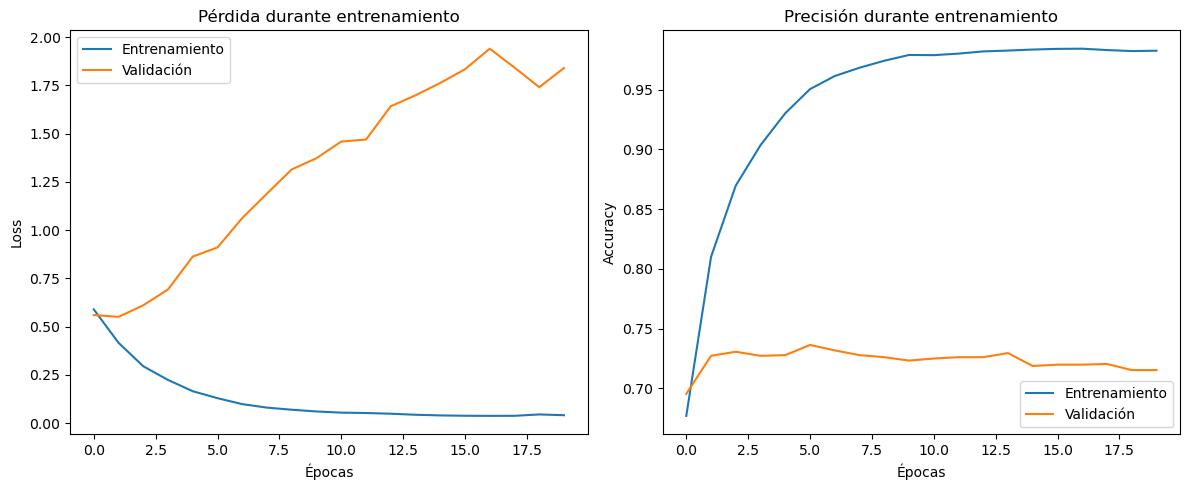

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Métricas de Predicción

El modelo entrenado alcanza una precisión global (accuracy) del 74%, lo que indica que aproximadamente tres de cada cuatro predicciones realizadas coinciden con la etiqueta real. Este valor, aunque no extremadamente alto, sí representa un desempeño aceptable considerando la naturaleza del problema y el tipo de datos utilizados. Más allá del valor general de precisión, es clave examinar las métricas específicas por clase para tener una comprensión más profunda del comportamiento del modelo.

In [56]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

69/69 [==============================] - 1s 13ms/step


Para la clase Negativo, se observa una precisión del 75% y un recall del 72%. Esto significa que el modelo acierta en tres de cada cuatro ocasiones cuando predice que un mensaje es negativo, pero también que logra identificar correctamente el 72% de los mensajes que realmente lo son. El valor de f1-score, que resume precisión y recall en una sola métrica balanceada, es de 0.73.

En contraste, la clase Positivo tiene una precisión ligeramente menor (74%), pero un recall mayor (77%), lo que indica que el modelo es más eficaz detectando los mensajes positivos, aunque con una pequeña disminución en exactitud. El f1-score de esta clase alcanza 0.75, lo que sugiere un rendimiento ligeramente más equilibrado que en la clase negativa. Tanto el promedio macro como el weighted average de las métricas principales (precisión, recall y f1-score) se mantienen en 0.74. El promedio macro da el mismo peso a ambas clases, mientras que el promedio ponderado tiene en cuenta la proporción de cada clase en el conjunto de datos. El hecho de que ambos coincidan sugiere que no existe un desbalance severo entre clases ni un sesgo fuerte del modelo hacia una de ellas.

In [57]:
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))



 Reporte de clasificación:
              precision    recall  f1-score   support

    Negativo       0.75      0.72      0.73      1075
    Positivo       0.74      0.77      0.75      1125

    accuracy                           0.74      2200
   macro avg       0.74      0.74      0.74      2200
weighted avg       0.74      0.74      0.74      2200



In [59]:
auc = roc_auc_score(y_test, y_pred_probs)
print(f"\nAUC: {auc:.4f}")


AUC: 0.8071


```{admonition} Curva ROC y AUC
La curva ROC (Receiver Operating Characteristic) representa la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) a diferentes umbrales de decisión. El área bajo esta curva, conocida como AUC (Area Under the Curve), es una métrica robusta para evaluar el desempeño general de un modelo de clasificación binaria, especialmente en escenarios donde el balance entre clases puede influir en la precisión simple.
```

En este caso, el modelo alcanza un AUC de 0.8071, lo que indica un rendimiento sólido y superior al azar (un modelo aleatorio tendría un AUC de 0.5). Este valor sugiere que, en el 80.71% de los casos, el modelo es capaz de asignar una puntuación más alta a una observación positiva que a una negativa. En términos prácticos, esto implica que el modelo tiene una buena capacidad para discriminar entre mensajes positivos y negativos, independientemente del umbral de clasificación específico. Un AUC por encima de 0.8 se considera generalmente aceptable en tareas de clasificación de texto, y más aún cuando se trabaja con datos ruidosos o con estructuras lingüísticas complejas como en el análisis de sentimiento. No obstante, el hecho de no acercarse a valores más altos (como 0.9 o más) también deja en evidencia que aún hay margen de mejora en la capacidad discriminativa del modelo.

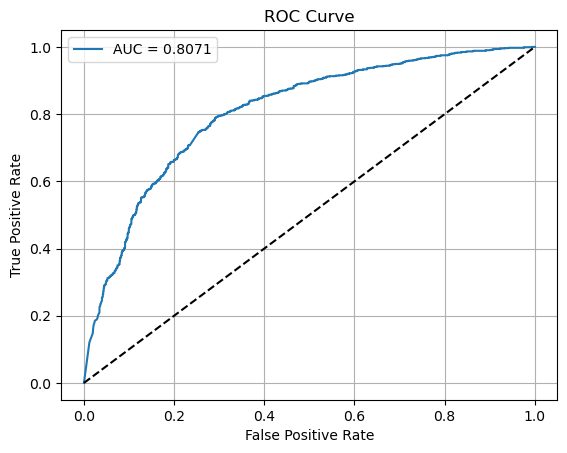

In [60]:
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

La matriz de confusión permite examinar de forma más precisa cómo se comporta el modelo en términos de errores y aciertos específicos para cada clase. En este caso, el modelo clasificó correctamente 775 ejemplos negativos (verdaderos negativos) y 861 ejemplos positivos (verdaderos positivos), lo cual indica un desempeño sólido en ambos casos. Sin embargo, también se presentaron 300 falsos positivos, es decir, ejemplos que eran realmente negativos pero fueron clasificados como positivos, y 264 falsos negativos, que corresponden a casos positivos mal clasificados como negativos. Este patrón revela que el modelo presenta una ligera tendencia a sobrestimar la clase positiva, cometiendo más errores al identificar textos negativos que al identificar los positivos. Aun así, el número de verdaderos positivos supera con claridad a los falsos negativos, lo que respalda el valor relativamente alto del recall para la clase positiva (0.77) reportado anteriormente. Del mismo modo, la precisión en la clase negativa se mantiene estable (0.75), a pesar de los falsos positivos.

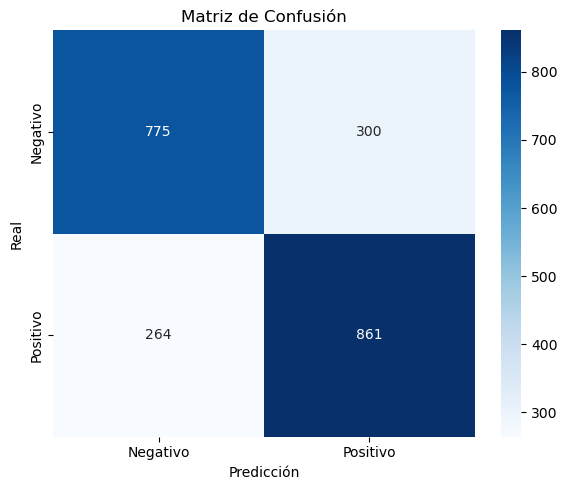

In [58]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()